# N-BEATS Lightninig M4

**N-BEATS** N- is a neural network based time series forecasting algorithm that was introduced in a paper by Oreshkin, et al. The algorithm has shown strong performance on a variety of time series forecasting benchmarks.

In this notebook, we will explore the Pytorch Lightning implementation of the N-BEATS algorithm, and apply it to the Monthly dataset from the M4 Time series analysis competition.

### N-BEATS Algorithm
N-BEATS consists of a stack of fully connected neural network blocks, where each block is trained to forecast the target time series. The unique aspect of N-BEATS is its ability to handle a wide range of time series forecasting problems without requiring any prior knowledge about the data.  Therefore, N-BEATS, unlike other neural network based forecasting algorithms, does not require any feature engineering or scaling of the data.  The algorithm is also able to handle multiple seasonalities and long term trends.


### M4 Competition

The **M4 Competition** is a well-known benchmark in the time series forecasting community. The competition, which took place in 2018, was the fourth iteration of the Makridakis Competitions, named after forecasting expert Spyros Makridakis. The M4 competition built upon the legacy of the previous M-Competitions (M1, M2, and M3) by providing a large dataset consisting of 100,000 time series from a variety of domains including finance, economics, demography, and others.

The primary objective of the competition was to identify the most accurate and robust forecasting methods for time series data, and to introduce deep learning into the analysis techniques, Participants were challenged to develop forecasting models that could perform well across a broad range of time series data with varying characteristics.

This competition attracted a considerable number of participants from across the globe, including academics, practitioners, and organizations, further advancing the field of time series forecasting by unveiling novel methods and insights. N-BEATS was not one entries into the competition, as the paper was published a year after its conclusion.  However, teh authors demonstrated state-of-the-art performance with N-BEATS for all the datasets in M4, improving forecast accuracy by 11% over a statistical benchmark and by 3% over the winner of the M4 competition. Unlike M4's winner, N-BEATS does not employ any time-series-specific components and its performance suggests that deep learning primitives such as residual blocks are by themselves sufficient to solve a wide range of forecasting problems. The Generic N-BEATS model used in this notebook uses as little prior knowledge as possible, with no feature engineering, no scaling, and no internal architectural components that may be considered time series specific.

### M4 Dataset

The M4 dataset comprises a collection of time series data intended for the M4 Forecasting Competition. This dataset is divided into three categories: Yearly, Quarterly, and Monthly data, with a total of 100,000 time series. Each time series varies in length, with the minimum, mean, and maximum lengths specified for each category. The dataset aims to provide a comprehensive basis for evaluating and comparing the performance of various forecasting methods.  The dataset is included unmodified in this repository, and can be found in the `data` directory.

In [2]:
from nbeats_lightning.nbeats import *
from nbeats_lightning.losses import *
from nbeats_lightning.loaders import *

import tensorboard as tb

import torch
import numpy as np
import pandas as pd

import lightning.pytorch as pl
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch import loggers as pl_loggers
import pandas as pd
from IPython.display import Markdown as md
from tqdm.notebook import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt


def get_M4infofile_info(info_file, seasonal_period, forecast_multiplier, category = None):
  
  """Reads the M4_info file and returns the frequency, forecast, backcast, and
     indicies for the specified category if any.

  Returns:
      (int,int,int,[int]): frequency, forecast_length, backcast_length, indicies
  """
  
  data_info  = pd.read_csv(info_file, index_col=0)
  data_id_info = data_info.loc[seasonal_period[0] + f"{1}"]
  frequency = data_id_info.Frequency
  forecast_length = data_id_info.Horizon
  backcast_length = data_id_info.Horizon * forecast_multiplier
  
  if category is not None:
    mask = (data_info.index.str.startswith(seasonal_period[0])) & (data_info.category == category)
    category_subset = data_info[mask]
    indicies = category_subset[mask].index
    
  else:
    indicies = None
  
  return frequency, forecast_length, backcast_length, indicies

The M4-info.csv file contains metadata for the M4 dataset, which consist of 6 individual files, one for each of the Yearl, Quarterly, Monthly, Weekly, Daily, and Hourly observation requencies. The metadata provides information about the time series in each file, including the category, frequency, starting date, forecasting horizon, seasonality, and length of each time series.

Here are the names and descriptions of each of the columns in the M4-info.csv file:

- *M4id*: The unique identifier for each time series in the M4 dataset.
- *Category*: The category to which each time series belongs (Yearly, Quarterly, or Monthly).
- *Frequency*: The frequency of the observations in each time series.
- *StartingDate*: The starting date of each time series. Initially not provided in M4, but added aterwards when the competitive implementations were made available.
- *ForecastHorizon*: The forecasting horizon for each time series, indicating the number of periods ahead that forecasts are required.
- *Seasonality*: The seasonality of each time series, indicating the number of periods in a seasonal cycle.
- *Length*: The total number of observations in each time series.


In [3]:
# Load data
#%% Begining of Notebook Cell
# Set M4 data parameters

# Hourly, Daily, Weekly, Monthly, Quarterly, Yearly
seasonal_period= "Monthly"

# Any index will do since we are just loading a representative entry from the M4Info.csv file to gather data parameters
data_index = 1 

# The backcast length is determined by multiplying the forecast horizon by an integer multiplier
forecast_multiplier = 5

# Set to a category name to train on a single M4 category
category = 'Macro' 

# Set True to reduce the training size to 1000 series. Useful when exploring hyperparameters and debugging.
debug = False

# file locations
info_file  = "data/M4/M4-info.csv"
train_file = f"data/M4/Train/{seasonal_period}-train.csv"
test_file  = f"data/M4/Test/{seasonal_period}-test.csv"

# Get data parameters from M4Info.csv file
frequency, forecast_length, backcast_length, indicies = get_M4infofile_info(
  info_file, seasonal_period, forecast_multiplier, category)

In this notebook we will build a model to analyze a Maco economics subset of the Monthly data.

In [4]:
def load_train_data(train_file, debug = False, indicies=None):
    """Loads the training data from the M4 dataset specified by the train_file parameter.

    Args:
        train_file (string): Path to the M4 training data file. 
        debug (bool, optional): Limits training data to first 1000 rows. 
                                Defaults to False.
        indicies (Index, optional): Indexes of selected category.
                                Defaults to None.

    Returns:
        Tensor : Train data
    """
    all_train_data = pd.read_csv(train_file, index_col=0)
          
    if indicies is not None:
      all_train_data = all_train_data.loc[indicies]
    
    if debug:
      all_train_data[:1000]
      
    return all_train_data

def load_test_data(test_file, debug = False, indicies = None):
    """Loads the test data from the M4 dataset specified by the test_file parameter.

    Args:
        test_file (string): Path to the M4 test data file.
        debug (bool, optional): Limits data to first 100 rowes Defaults to False.
        indicies (Index, optional): Indexes of selected category. Defaults to None.

    Returns:
        _type_: _description_
    """
    all_test_data = pd.read_csv(test_file, index_col=0)
    
    if indicies is not None:
      all_test_data = all_test_data.loc[indicies]
      
    if debug:
      all_test_data[:1000]
            
    return all_test_data

train_data = load_train_data(train_file, debug, indicies)
test_data = load_test_data(test_file, debug, indicies)
train_data.head()

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V2786,V2787,V2788,V2789,V2790,V2791,V2792,V2793,V2794,V2795
M4id,,,,,,,,,,,,,,,,,,,,,
M1,8000.0,8350.0,8570.0,7700.0,7080.0,6520.0,6070.0,6650.0,6830.0,5710.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M2,2440.0,2490.0,2710.0,2290.0,1960.0,1990.0,1960.0,2530.0,2640.0,2650.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M3,2670.0,2590.0,2784.0,2816.0,2888.0,2906.0,2839.0,2860.0,2798.0,2795.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M4,7264.0,7215.0,7022.0,7040.0,6966.0,6984.0,7025.0,7082.0,6956.0,7014.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M5,4210.0,4290.0,4250.0,4320.0,4320.0,4330.0,4320.0,4260.0,4220.0,4260.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The training data consists of 10016 individual timeseries from the Macro Economic Monthly data. The number of observations of each time series is not consistent and nether is the general magnitude of the values.  To test the assumption that N-BEATS can be used for forecasting time series with different scales and without the need to feature engineer, we will not scale the data before feeding it into the model.

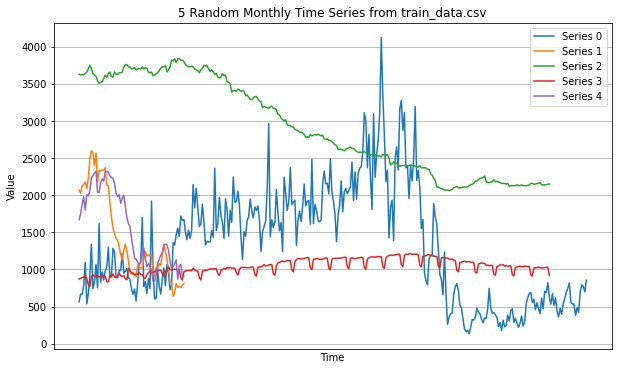

In [5]:
# Randomly select 5 time series
random_series = train_data.sample(n=5, random_state=42)

# Reset the index of the DataFrame to get numerical indices
random_series_reset_index = random_series.reset_index(drop=True)

# Plot each time series on a single graph
plt.figure(figsize=(10, 6))
for index, row in random_series_reset_index.iterrows():
    plt.plot(row.index, row.values, label=f'Series {index}')

plt.title('5 Random Monthly Time Series from train_data.csv')
plt.xlabel('Time')
plt.xticks([])
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

Let's create a heat map to visualize the distribution of values across the time series in the dataset. In this heat map, each row will correspond to a different time series, while each column will correspond to a different time point. This will allow us to see how the values change over time across different time series.

To make the visualization more interpretable, I will randomly select a subset of 100 time series from the dataset instead of using the entire dataset. This will make it easier to observe any patterns or trends in the data.

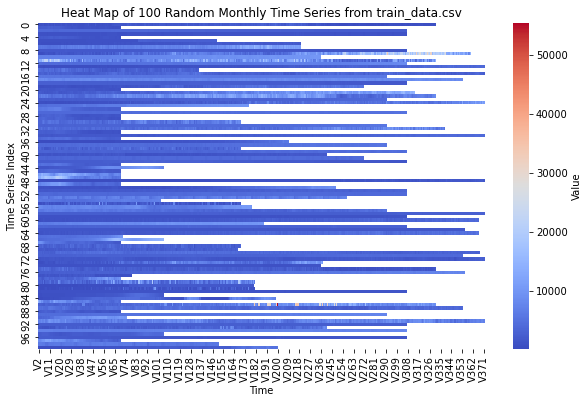

In [6]:
import seaborn as sns

# Randomly select 100 time series
subset = train_data.sample(n=100, random_state=42)


# Reset the index of the DataFrame to get numerical indices
subset_int_index = subset.reset_index(drop=True)
subset_int_index = subset_int_index.drop(columns= subset_int_index.columns[370:] ) 


# Generate a heat map
plt.figure(figsize=(10, 6))
sns.heatmap(subset_int_index, cmap='coolwarm', cbar_kws={'label': 'Value'})
plt.title('Heat Map of 100 Random Monthly Time Series from train_data.csv')
plt.xlabel('Time')
plt.ylabel('Time Series Index')
plt.show()


In the heat map above, each row corresponds to a different time series, and each column corresponds to a different time point. The color represents the value of the time series at each time point, with darker red colors indicating higher values and darker blue colors indicating lower values.

This visualization allows us to observe the distribution of values across different time series and time points, providing a high-level overview of the dynamics in the dataset.

### Define the Model

In this notebook we will define a Generic mode which is sufficiently deep to capture the dynamics of the time series in the dataset. The model will be trained using the Adam optimizer, with a learning rate of 1e-5. The model will be trained for 1000 epochs, with a batch size of 1024.

We mirror or the most part the N-BEATS paper's choice of hyperparameters to ensure a fair comparison between the two models.

- *Generic N-BEATS*:
    - *Number of stacks*: 10
    - *Number of blocks per stack*: 1 
    - *Number of layers*: 4
    - *Width of layers*: 512
    - *Learning rate*: 1e-5
    - *Batch size*: 1024
    - *Epochs*: 1000
    - *Share Weights*: False
    - *Loss function*: `SMAPELoss`
    - *Optimizer*: `AdamW` (Slightly faster than `Adam`)
    - *Activation*: `LeakyRELU` (Slightly faster than `RELU`)

The Symmetric Mean Absolute Percentage Error (SMAPE) is a commonly used loss function, especially in time series forecasting, because of its easy interpretability. It measures the accuracy of a forecast by computing the symmetrically scaled percentage error. Unlike Mean Absolute Percentage Error (MAPE), SMAPE has a bounded range [0, 200], which can be more desirable in some settings.

The formula for SMAPE between two vectors \( \mathbf{y} \) (actual values) and \( \hat{\mathbf{y}} \) (predicted values) for \( n \) data points is given by:

$$
{SMAPE}(\mathbf{y}, \hat{\mathbf{y}}) = \frac{200}{H} \sum_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{(|y_i + \hat{y}_i|)/2}
$$

where:
- $y_i$ is the actual value for the $i$-th data point,
- $\hat{y}_i$ is the predicted value for the $i$-th data point,
- $n$ is the total number of data points.
- $H$ is the forecasting horizon.

The division by $(|y_i + \hat{y}_i|)/2$ is what makes the percentage error symmetric. This term normalizes the error based on the magnitudes of the actual and predicted values, which helps in bringing a balance, especially when the actual value $ y_i $ is small.

The network is very large (10 stacks) and will take a long time to train. However, the model capacity is needed to capture the breadth and depth of the time series in the dataset.


In [7]:
# Set model hyperparameters
optimizer_name = 'AdamW'
loss = 'SMAPELoss'
activation = "LeakyReLU"
generic_architecture = True
weight_share = False
learning_rate = 1e-5
thetas_dim = 5
g_width = 512
n_blocks_per_stack = 1
n_stacks = 10
active_g = True

# Set trainer hyperparameters
batch_size = 1 # N-BEATS paper uses 1024
val_nepoch = 1 # perform a validation check every n epochs
max_epochs = 32
train = True # set to True to train the model
test = True # set to True to test the model
split_ratio = 0.8
fast_dev_run = False  # set to True to run a single batch through the model for debugging purposes
debug = False # set to True to limit the size of the dataset for debugging purposes

# Set precision to 32 bit
torch.set_float32_matmul_precision('medium')

# Set chkpoint to a path to load a previous model
chkpoint = None


In [8]:
# Load a previous model or create a new one
if chkpoint is not None:  
  model = NBeatsNet.load_from_checkpoint(chkpoint)
else:
  model = NBeatsNet(
    backcast = backcast_length,
    forecast = forecast_length, 
    generic_architecture = generic_architecture,
    n_blocks_per_stack = n_blocks_per_stack,
    n_stacks = n_stacks,
    share_weights = weight_share,
    thetas_dim = thetas_dim,
    learning_rate = learning_rate,
    loss = loss,  
    optimizer_name = optimizer_name,
    frequency=frequency,
    g_width=g_width,
    active_g = active_g
  )
  
#%% 
if generic_architecture:
  arch = 'Generic'
else :
  arch = 'Interpretable'

if active_g:
  actg = 'active_g'
else:
  actg = ''

# the model name is derived from the parameters used to train the model
name = f"{arch}-{category}_{seasonal_period}-[{backcast_length}:{forecast_length}]-s[{n_stacks}:{n_blocks_per_stack}:{g_width}]_{actg}" 
print("Model Name :", name)
print (model)


Model Name : Generic-Macro_Monthly-[90:18]-s[10:1:512]_active_g
NBeatsNet(
  (loss_fn): SMAPELoss()
  (stacks): ModuleList(
    (0-9): 10 x ModuleList(
      (0): GenericBlock(
        (activation): ReLU()
        (fc1): Linear(in_features=90, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=512, bias=True)
        (fc3): Linear(in_features=512, out_features=512, bias=True)
        (fc4): Linear(in_features=512, out_features=512, bias=True)
        (backcast_linear): Linear(in_features=512, out_features=5, bias=True)
        (forecast_linear): Linear(in_features=512, out_features=5, bias=True)
        (backcast_g): Linear(in_features=5, out_features=90, bias=False)
        (forecast_g): Linear(in_features=5, out_features=18, bias=False)
      )
    )
  )
)


Define the logger, the chkpoint directory, and the trainer.

In [9]:

# define a tensorboard loger
tb_logger = pl_loggers.TensorBoardLogger(save_dir="lightning_logs/", name=name)

# define a model checkpoint callback
chk_callback = ModelCheckpoint(
  save_top_k = 2,
  monitor = "val_loss",
  mode = "min",
  filename = "{name}-{epoch:02d}-{val_loss:.2f}",
)

trainer =  pl.Trainer(
    accelerator='auto'
    ,max_epochs=max_epochs   
    ,fast_dev_run=fast_dev_run
    ,logger=[tb_logger]
    ,check_val_every_n_epoch=val_nepoch 
    ,callbacks=[chk_callback]  
  )


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Train the Model  

This will take a while depending on your available hardware, the number of epochs, the number of trainable parameters, and the size of the dataset.

In [10]:
# Train and run a final validation on the model
if train:

  dmc = TimeSeriesCollectionDataModule(
    train_data=train_data, 
    backcast=backcast_length, 
    forecast=forecast_length, 
    batch_size=batch_size, 
    split_ratio=split_ratio
    )
  trainer.fit(model, datamodule=dmc, ckpt_path=chkpoint)
  trainer.validate(model, datamodule=dmc)


Missing logger folder: lightning_logs/Generic-Macro_Monthly-[90:18]-s[10:1:512]_active_g


To get a better model to tst against the M4 dataset, you would probalby want to retrain your model or continue training this model for extra epochs with the no_val = True.  This will forces the Dataloader to use the entire train_data set for training, and force the model to skip the validation step.  This will allow the model to train on the entire dataset, and not just the 80% of the data that is used for training by default. 

### Test the Model

Finally we test the model against the unseen test data.  The test data is the final {backcast_length} insample data points from the M4 dataset of each time series merged with the first {forecast_length} out of sample data points from test_data.  

In [ ]:
# Test the model with the in-sample data from the trianing set 
# merged with the out-of-sample data from the test set
if test:
  
  test_module = TimeSeriesCollectionTestModule(
    test_data=test_data, 
    train_data=train_data,
    backcast=backcast_length, 
    forecast=forecast_length, 
    batch_size=batch_size
  )
  trainer.test(model, datamodule=test_module)
  